# Taking off the Training Weels: Re-Balancing the Citibike System

**Author: Mitchell Krieger**
***

## Modeling

These models attempt to predict how many bikes are availble at a given station at a given time. Starting by isolating a typical 2 week interval to see if models are able to capture both daily and weekly seasonality. June 17th - June 30th, 2018 was chosen for its good weather, lack of significant holidays, and consistency of data collection across all stations (no missing values). Yearly seasonality will be set aside for now.

**Importing Relevant Packages**

In [1]:
import requests
import json
import sys, os 
import numpy as np
import datetime as dt
import pandas as pd


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
plt.style.use('seaborn')

from cleaning import *
from station import *
from hidden_printing import Hidden_Printer
import pickle

### Check for stationarity

Before modeling can begin, we need to ensure that each time series is stationary. Using the Dickey-Fuller test, we'll test for stationarity and isolate stations that are not. In addition, data will be resampled hourly to prep for models that require it.

In [3]:
#load in data and transform to a resampled hourly time x station matrix in a dataframe
year_2018 = pickle.load(open('./pickle/historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
station_mat.columns = [str(col) for col in station_mat.columns]


#interpolate timeseries with small amounts of  missing values
station_mat = station_mat.interpolate()

#drop station colums that have large amount of missing data due to installation/discontinuation 
# or major malfunction in 2018
station_drop = list(station_mat.isna().sum().sort_values(ascending=False).head(45).index)
station_mat.drop(columns=station_drop,inplace=True)

station_mat.head()

,72,79,82,83,116,119,120,127,128,143,...,3478,3481,3486,3489,3490,3491,3492,3493,3494,3495
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,0.0,12.0,7.0,5.0,10.5,12.5,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.5,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.0,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0


**Dickey-Fuller Test**

Here we will iterate over columns and store result of test in dataframe. A value of True means that the null hypothesis of the dickey fuller test as been rejected, implying stationarity. This doesn't garuantee stationarity but it gives us an idea of how many stations are extremely unstationary.

In [4]:
dickey_results = pd.Series()

with Hidden_Printer(): #supresses Dickey-Fuller function's print
    
    for col in station_mat.columns:
      dftest = dickey_fuller(station_mat[col])
      dickey_results[col] = dftest


dickey_results.value_counts()

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


True     656
False      8
dtype: int64

Only 8 stations failed the dickey fuller test. Taking a closer look at each one by plotting them:

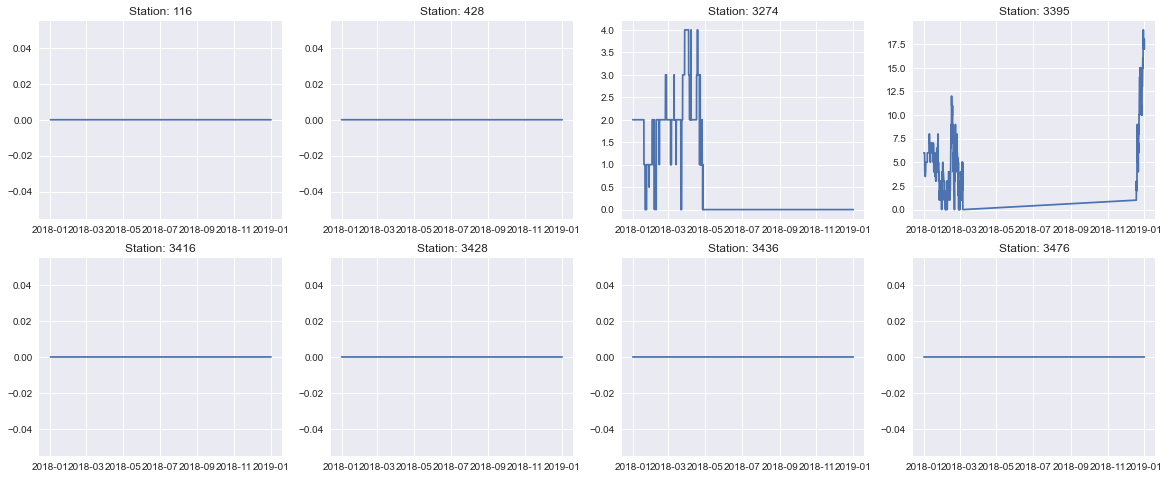

In [5]:
investigate = dickey_results.loc[dickey_results == False]

fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(20,8))

for i, ts in enumerate(investigate.index):
  ax[i//4][i%4].plot(station_mat[ts])
  ax[i//4][i%4].set_title(f'Station: {ts}')

It seems these fail the dickey-fuller test because they are actually stations that should have been dropped due to their lack of data. We'll remove them from out station matrix

In [6]:
station_mat.drop(columns=investigate.index,inplace=True)

### The Typical Station

For our inital models we'll use Station 3172 on the Upper West stide as our training data to examine the intricacies of station time series during our two week interval of June 17th - June 30th, 2018.

In [7]:
station_3172 = Station(3172)
station_3172.info()


        #### Station 3172 Info ####
        
        Name: W 74 St & Columbus Ave
        Status: active
        Legacy ID: 3172
        Type: classic
        Region: NYC District 
        Coordinates: (40.7785669,-73.97754961)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        
        As of: 2020-12-16 18:32:59
        Capacity: 27
        Available Bikes: 6
        Available Docks: 20
        Disabled Bikes: 1
        Disabled Docks: 0
        


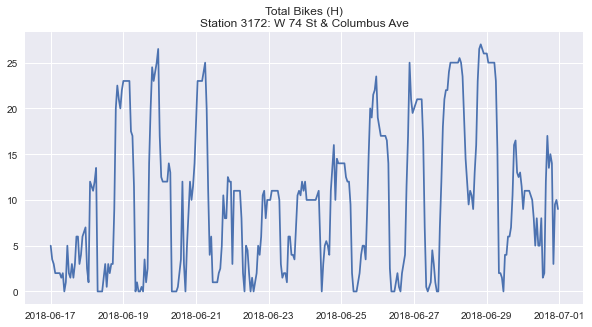

In [8]:
station_3172.plot_avail_bikes(time_interval=('2018-06-17','2018-06-30'))

You can see the typical weekly and daily seasonailty found in the Exploratory data analysis in this plot. On weekdays during the morning the morning there are many bikes taken from the station and then they are returned in the evening. Traffic on weekends is slower and Tuesdays, Wednesday and Thursdays are the most active days.

Using seasonal decomposition to be more isolate about this trend:`

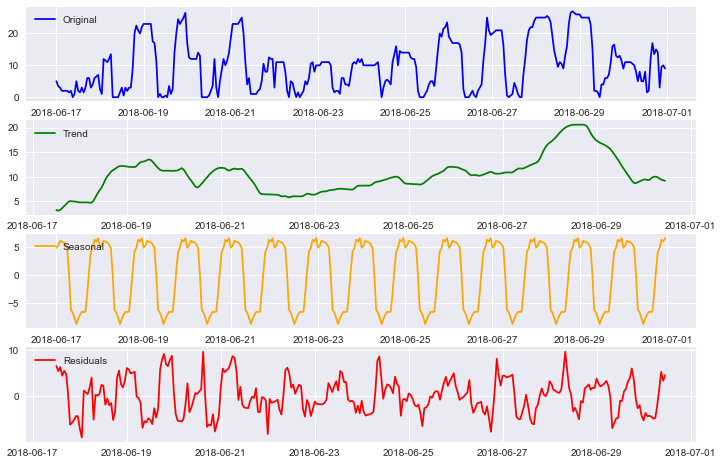

In [10]:
station_3172.availbike_decompose(time_interval=('2018-06-17','2018-06-30'))

The trend line somewhat shows the weekly seasonality, but doesn't capture it completely. The last weekend in June is also Pride weekend, which would be causing some of the irregularies in the daily and weekly seasonality on those days.

For modeling purposes, we'll get the time series itself from the station class:

In [12]:
train_ts = station_3172.avail_bikes_ts(time_interval=('2018-06-17','2018-06-30'))

## Dummy Model

To get a baseline model we'll create a dummy model that predicts the mean of the time series for all future timesteps

In [ ]:
arima = ARIMA()